In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentiment-prediction-on-movie-reviews/movies.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/sample.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/train.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/test.csv


In [2]:
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
from sklearn.preprocessing import  MinMaxScaler,OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_selection import SelectKBest, chi2, SelectPercentile
from sklearn.decomposition import PCA
from category_encoders import BinaryEncoder, TargetEncoder, HashingEncoder
from sklearn.metrics import precision_recall_curve, roc_curve, auc

from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier,VotingClassifier, BaggingClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB, ComplementNB

import re
import string
import warnings

import seaborn as sns
import matplotlib.pyplot as plt

# Data Loading

In [3]:
train_data=pd.read_csv("/kaggle/input/sentiment-prediction-on-movie-reviews/train.csv")
movie_data=pd.read_csv("/kaggle/input/sentiment-prediction-on-movie-reviews/movies.csv")
test_data=pd.read_csv("/kaggle/input/sentiment-prediction-on-movie-reviews/test.csv")

In [4]:
print(train_data.shape, movie_data.shape, test_data.shape)

(162758, 5) (143258, 14) (55315, 4)


# Step 1: Preliminary investigation

**a) Examination of train data**

In [5]:
train_data.head()

,movieid,reviewerName,isFrequentReviewer,reviewText,sentiment
0,marvelous_pirate,Benjamin Henry,False,Henry Selick’s first movie since 2009’s Corali...,POSITIVE
1,tony_montana_frodo_baggins_v_rocky_balboa,Felicia Lopez,False,With a cast that reads like the Vogue Oscar pa...,NEGATIVE
2,darth_vader_katniss_everdeen_sorcerer_donnie_d...,Mr. Charles Burgess,True,Creed II does not give us anything but another...,POSITIVE
3,lara_croft_glimmer,Ryan Barrett,False,"I know what you're thinking, but this is no Li...",POSITIVE
4,jason_bourne_surreal_the_terminator_indiana_jones,Alexander Glover,False,Director Fernando Meirelles tells the story wi...,POSITIVE


In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162758 entries, 0 to 162757
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   movieid             162758 non-null  object
 1   reviewerName        162758 non-null  object
 2   isFrequentReviewer  162758 non-null  bool  
 3   reviewText          156311 non-null  object
 4   sentiment           162758 non-null  object
dtypes: bool(1), object(4)
memory usage: 5.1+ MB


Note: In train_data, only the reviewText column has null values

In [7]:
train_data.isna().sum()

movieid                  0
reviewerName             0
isFrequentReviewer       0
reviewText            6447
sentiment                0
dtype: int64

In [8]:
from sklearn.utils.multiclass import type_of_target
type_of_target(train_data['sentiment'])

'binary'

**Type of the target varable is 'binary'**

In [9]:
train_data['sentiment'].unique()

array(['POSITIVE', 'NEGATIVE'], dtype=object)

**Unique values of 'sentiment' columns are "POSITIVE" and 'NEGATIVE'**

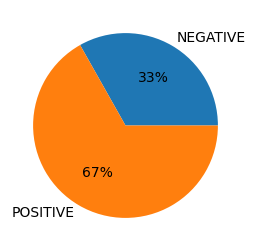

In [10]:
unique, counts = np.unique(train_data['sentiment'], return_counts=True)
plt.figure(figsize=(3,3))
plt.pie(counts, labels=unique, autopct='%.0f%%');

**Note: The number of data points in the 'POSITIVE' class is significantly higher than in the 'NEGATIVE' class. This class distribution indicates an imbalance dataset**

In [11]:
positive_sentiment=train_data[train_data['sentiment']=='POSITIVE']
negative_sentiment=train_data[train_data['sentiment']=='NEGATIVE']

In [12]:
str(positive_sentiment['reviewText'])

'0         Henry Selick’s first movie since 2009’s Corali...\n2         Creed II does not give us anything but another...\n3         I know what you\'re thinking, but this is no Li...\n4         Director Fernando Meirelles tells the story wi...\n5         "Kajillionaire" is a rich piece of storytellin...\n                                ...                        \n162750    Our Children isn\'t simply a story of a mother ...\n162752    Spectacular action set-pieces, clever writing ...\n162753    A top-notch thriller with genuine surprises an...\n162755    This fun, gentle comedy focuses mainly on them...\n162757            A peerless exercise in stimulus response.\nName: reviewText, Length: 108761, dtype: object'

(-0.5, 399.5, 199.5, -0.5)

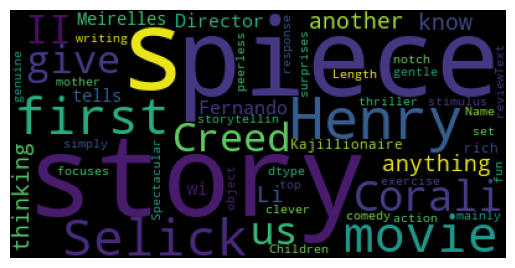

In [13]:
from wordcloud import WordCloud
wc=WordCloud().generate(str(positive_sentiment['reviewText']))
plt.imshow(wc);
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

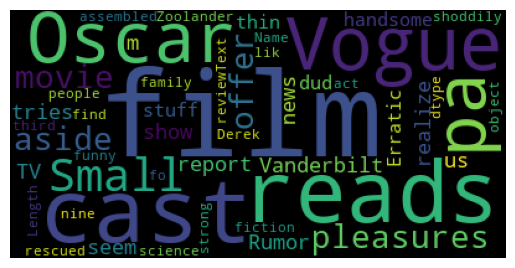

In [14]:
from wordcloud import WordCloud
wc2=WordCloud().generate(str(negative_sentiment['reviewText']))
plt.imshow(wc2);
plt.axis('off')

**b) Examination of movie_data:**

In [15]:
movie_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143258 entries, 0 to 143257
Data columns (total 14 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   movieid               143258 non-null  object 
 1   title                 143258 non-null  object 
 2   audienceScore         73248 non-null   float64
 3   rating                13991 non-null   object 
 4   ratingContents        13991 non-null   object 
 5   releaseDateTheaters   30773 non-null   object 
 6   releaseDateStreaming  79420 non-null   object 
 7   runtimeMinutes        129431 non-null  float64
 8   genre                 132175 non-null  object 
 9   originalLanguage      129400 non-null  object 
 10  director              143258 non-null  object 
 11  boxOffice             14743 non-null   object 
 12  distributor           23005 non-null   object 
 13  soundType             15917 non-null   object 
dtypes: float64(2), object(12)
memory usage: 15.3+ MB


Note: The movie data contains two numerical features

In [16]:
movie_data.head()

,movieid,title,audienceScore,rating,ratingContents,releaseDateTheaters,releaseDateStreaming,runtimeMinutes,genre,originalLanguage,director,boxOffice,distributor,soundType
0,han_solo_heroic_myth_wonder_woman,Han Solo Heroic Myth Wonder Woman,50.0,NaN,NaN,NaN,2018-08-25,75.0,"Comedy, Horror, Sci-fi",English,Claude Nicolet,NaN,NaN,NaN
1,voyage_tyler_durden_han_solo_stardust,Voyage Tyler Durden Han Solo Stardust,NaN,NaN,NaN,NaN,2020-02-11,114.0,Drama,English,Nathan Haack,NaN,NaN,NaN
2,norman_bates_ferris_bueller_hermione_granger_v...,Norman Bates Ferris Bueller Hermione Granger V...,43.0,NaN,NaN,NaN,NaN,120.0,Drama,Korean,Theresa Smith,NaN,NaN,NaN
3,elegant_hermione_granger,Elegant Hermione Granger,60.0,NaN,NaN,NaN,2020-10-23,90.0,"Action, Mystery & thriller",English,Donald Lewis,NaN,NaN,NaN
4,adventure_rocky_balboa,Adventure Rocky Balboa,70.0,NaN,NaN,NaN,2017-03-27,80.0,"Fantasy, Adventure, Animation",English,Howard Simms,NaN,NaN,NaN


Observation: movieid and title columns looks similar

In [17]:
movie_data.isnull().sum()

movieid                      0
title                        0
audienceScore            70010
rating                  129267
ratingContents          129267
releaseDateTheaters     112485
releaseDateStreaming     63838
runtimeMinutes           13827
genre                    11083
originalLanguage         13858
director                     0
boxOffice               128515
distributor             120253
soundType               127341
dtype: int64

In [18]:
movie_data.describe()

,audienceScore,runtimeMinutes
count,73248.000000,129431.000000
mean,55.674967,93.708578
std,24.553648,28.129175
min,0.000000,1.000000
25%,37.000000,84.000000
50%,57.000000,92.000000
75%,76.000000,103.000000
max,100.000000,2700.000000


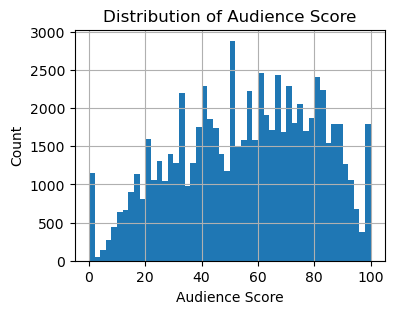

In [19]:
plt.figure(figsize=(4, 3))  
movie_data['audienceScore'].hist(bins=50)
plt.title('Distribution of Audience Score')
plt.xlabel('Audience Score')
plt.ylabel('Count')
plt.show()

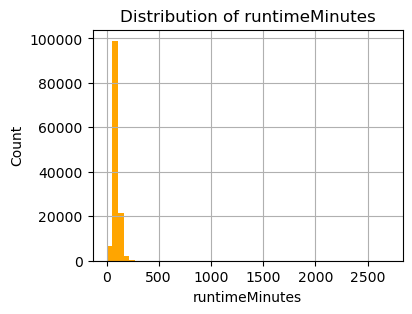

In [20]:
plt.figure(figsize=(4, 3))
movie_data['runtimeMinutes'].hist(bins=50, color='orange')
plt.title('Distribution of runtimeMinutes')
plt.xlabel('runtimeMinutes')
plt.ylabel('Count')
plt.show()

**c) Examination of test_data**

In [21]:
test_data.head()

,movieid,reviewerName,isTopCritic,reviewText
0,legend_marty_mcfly_oracle,John Kim,False,Green slowly cranks up the dread with style an...
1,terminator_katniss_everdeen_glimmer,Brian Chaney,False,Philip Noyce's direction is elegant and unforc...
2,james_bond_labyrinth_gollum,Danielle Parker,False,It wouldn't do to say what path Maria ultimate...
3,v_quest_han_solo_wondrous,Brittany Lane,False,Pig is not exactly the arthouse John Wick that...
4,enigma_hulk_surreal_starlight,Justin Willis,False,An imaginative no-budget musical of sorts abou...


Observation: In the training data, the column name is 'isFrequentReviewer', while in the test data it is 'isTopCritic'.


In [22]:
test_data.rename(columns={'isTopCritic': 'isFrequentReviewer'}, inplace=True)

In [23]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55315 entries, 0 to 55314
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   movieid             55315 non-null  object
 1   reviewerName        55315 non-null  object
 2   isFrequentReviewer  55315 non-null  bool  
 3   reviewText          52805 non-null  object
dtypes: bool(1), object(3)
memory usage: 1.3+ MB


In [24]:
test_data.isna().sum()

movieid                  0
reviewerName             0
isFrequentReviewer       0
reviewText            2510
dtype: int64

Note: To predict sentiment for these specific rows, we require an additional column

# Merging

** Feature engineering before merging

In [25]:
median_audience_score_per_movie = movie_data.groupby('movieid')['audienceScore'].median().reset_index()
movie_data = movie_data.merge(median_audience_score_per_movie, on='movieid', suffixes=('', '_new'))

In [26]:
movie_data=movie_data.dropna(subset=['audienceScore_new'])

In [27]:
movie_data=movie_data.drop_duplicates('movieid', keep='first')

In [28]:
movie_data.shape

(66187, 15)

In [29]:
#movie_data['audienceScore_new'] = movie_data['audienceScore_new'] ** 2

**1. Merging train_ and movie_ datasets based on the 'movieid' column**

In [30]:
merged_train=pd.merge(train_data, movie_data, on='movieid', how='left')
del merged_train['audienceScore']
merged_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162758 entries, 0 to 162757
Data columns (total 18 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   movieid               162758 non-null  object 
 1   reviewerName          162758 non-null  object 
 2   isFrequentReviewer    162758 non-null  bool   
 3   reviewText            156311 non-null  object 
 4   sentiment             162758 non-null  object 
 5   title                 159922 non-null  object 
 6   rating                98819 non-null   object 
 7   ratingContents        98819 non-null   object 
 8   releaseDateTheaters   125975 non-null  object 
 9   releaseDateStreaming  145600 non-null  object 
 10  runtimeMinutes        157466 non-null  float64
 11  genre                 158295 non-null  object 
 12  originalLanguage      157466 non-null  object 
 13  director              159922 non-null  object 
 14  boxOffice             109764 non-null  object 
 15  

 Examination of merged_train dataset 

In [31]:
merged_train.head(2)

,movieid,reviewerName,isFrequentReviewer,reviewText,sentiment,title,rating,ratingContents,releaseDateTheaters,releaseDateStreaming,runtimeMinutes,genre,originalLanguage,director,boxOffice,distributor,soundType,audienceScore_new
0,marvelous_pirate,Benjamin Henry,False,Henry Selick’s first movie since 2009’s Corali...,POSITIVE,Marvelous Pirate,PG-13,"['Violence', 'Brief Strong Language', 'Substan...",2022-10-21,2022-10-28,105.0,"Comedy, Animation, Adventure, Fantasy",English,Bennie Basso,NaN,Netflix,NaN,65.0
1,tony_montana_frodo_baggins_v_rocky_balboa,Felicia Lopez,False,With a cast that reads like the Vogue Oscar pa...,NEGATIVE,Tony Montana Frodo Baggins V Rocky Balboa,NaN,NaN,NaN,2013-01-08,91.0,Action,English,Alma White,NaN,NaN,NaN,47.0


In [32]:
merged_train.rename(columns={'sentiment': 'Sentiment'}, inplace=True)
merged_train.rename(columns={'audienceScore_new': 'audienceScore'}, inplace=True)

In [33]:
correlation_matrix = merged_train.corr(numeric_only=True)
print(correlation_matrix)

                    isFrequentReviewer  runtimeMinutes  audienceScore
isFrequentReviewer            1.000000       -0.032217      -0.024994
runtimeMinutes               -0.032217        1.000000       0.226000
audienceScore                -0.024994        0.226000       1.000000


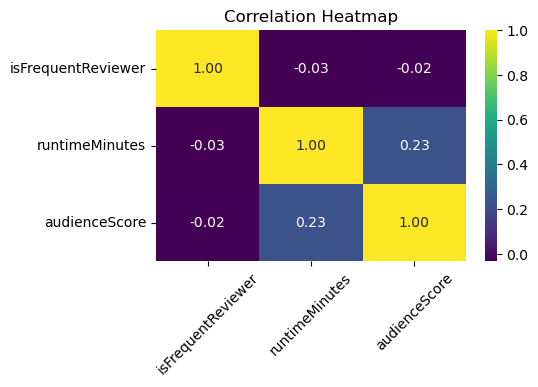

In [34]:
plt.figure(figsize=(5,3))
sns.heatmap(correlation_matrix, annot=True, cmap='viridis', fmt=".2f")
plt.title("Correlation Heatmap")
plt.xticks(rotation=45)  
plt.show()

**Note: There is weak positive correlation between 'audienceScore' and runtimeMinutes**

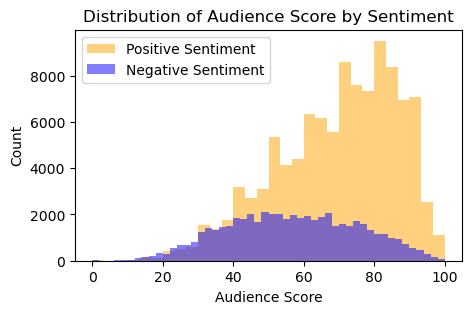

In [35]:
plt.figure(figsize=(5,3))
positive_scores = merged_train[merged_train['Sentiment'] == 'POSITIVE']['audienceScore']
plt.hist(positive_scores, bins=30, alpha=0.5, color='orange', label='Positive Sentiment')
negative_scores = merged_train[merged_train['Sentiment'] == 'NEGATIVE']['audienceScore']
plt.hist(negative_scores, bins=50, alpha=0.5, color='blue', label='Negative Sentiment')
plt.title('Distribution of Audience Score by Sentiment')
plt.xlabel('Audience Score')
plt.ylabel('Count')
plt.legend()
plt.show()

The above plot depicting AudienceScore by Positive Sentiment exhibits a left (negatively) skewed distribution, indicating that a majority of positive sentiment movies tend to have lower audience scores. On the other hand, the plot for AudienceScore by Negative Sentiment showcases a more normal distribution, suggesting that negative sentiment movies have a wider range of audience scores, with some movies receiving both low and high scores.

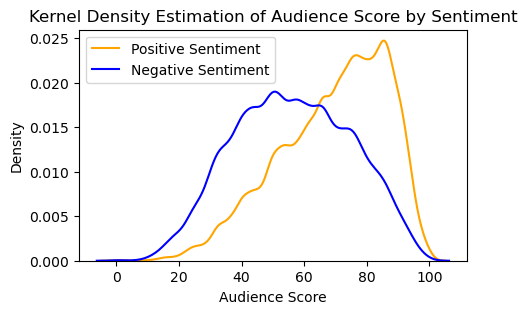

In [36]:
plt.figure(figsize=(5,3))

# Positive Sentiment KDE Plot
positive_scores = merged_train[merged_train['Sentiment'] == 'POSITIVE']['audienceScore']
sns.kdeplot(positive_scores, color='orange', label='Positive Sentiment')

# Negative Sentiment KDE Plot
negative_scores = merged_train[merged_train['Sentiment'] == 'NEGATIVE']['audienceScore']
sns.kdeplot(negative_scores, color='blue', label='Negative Sentiment')

plt.title('Kernel Density Estimation of Audience Score by Sentiment')
plt.xlabel('Audience Score')
plt.ylabel('Density')
plt.legend()
plt.show()


Note: AudienceScore by Positive Sentiment exhibits a left(negatively) skewed distribution and AudienceScore by Negative Sentiment showcases a more normal distribution

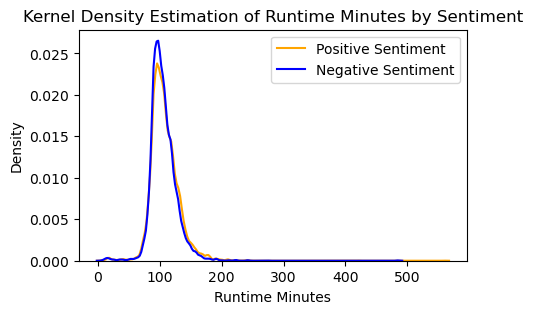

In [37]:
plt.figure(figsize=(5,3))
# Positive Sentiment KDE Plot
positive_runtime = merged_train[merged_train['Sentiment'] == 'POSITIVE']['runtimeMinutes']
sns.kdeplot(positive_runtime, color='orange', label='Positive Sentiment')
# Negative Sentiment KDE Plot
negative_runtime = merged_train[merged_train['Sentiment'] == 'NEGATIVE']['runtimeMinutes']
sns.kdeplot(negative_runtime, color='blue', label='Negative Sentiment')
plt.title('Kernel Density Estimation of Runtime Minutes by Sentiment')
plt.xlabel('Runtime Minutes')
plt.ylabel('Density')
plt.legend()
plt.show()

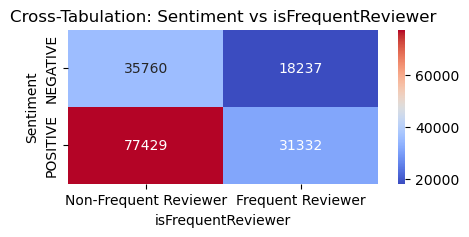

In [38]:
cross_tab_filtered = pd.crosstab(merged_train['Sentiment'], merged_train['isFrequentReviewer'], margins=True)
cross_tab_filtered = cross_tab_filtered.drop(columns='All', index='All')
plt.figure(figsize=(5, 2))
sns.heatmap(cross_tab_filtered, cmap='coolwarm', annot=True, fmt='d')

custom_labels = ['Non-Frequent Reviewer', 'Frequent Reviewer']
plt.xticks([0.5, 1.5], custom_labels)  
plt.title("Cross-Tabulation: Sentiment vs isFrequentReviewer")
plt.xlabel("isFrequentReviewer")
plt.ylabel("Sentiment")
plt.show()

Cross-tabulation is a tabular representation used to display the relationship between two or more categorical variables

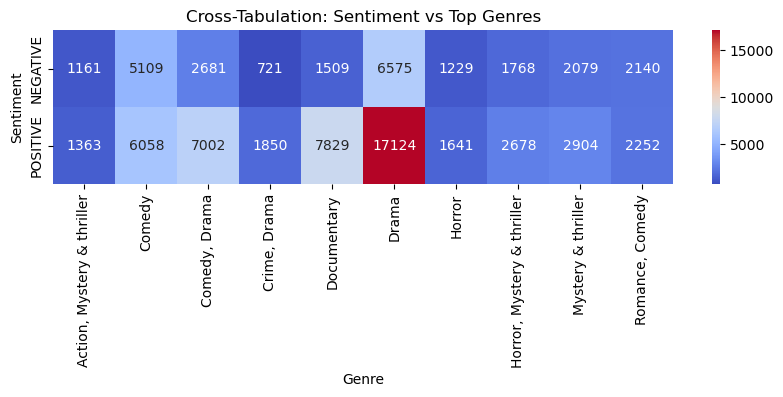

In [39]:
top_n = 10
top_genres = merged_train['genre'].value_counts().head(top_n).index
filtered_df = merged_train[merged_train['genre'].isin(top_genres)]

# Create a cross-tabulation for the filtered data
cross_tab_filtered = pd.crosstab(filtered_df['Sentiment'], filtered_df['genre'], margins=True)
cross_tab_filtered = cross_tab_filtered.drop(columns='All', index='All')
# Create a heatmap using Seaborn
plt.figure(figsize=(10,2))
sns.heatmap(cross_tab_filtered, cmap='coolwarm', annot=True, fmt='d')
plt.title("Cross-Tabulation: Sentiment vs Top Genres")
plt.xlabel("Genre")
plt.ylabel("Sentiment")
plt.show()

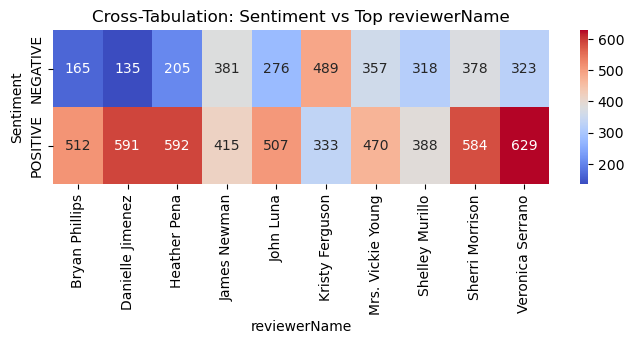

In [40]:
top_n = 10
top_genres = merged_train['reviewerName'].value_counts().head(top_n).index
filtered_df = merged_train[merged_train['reviewerName'].isin(top_genres)]

# Create a cross-tabulation for the filtered data
cross_tab_filtered = pd.crosstab(filtered_df['Sentiment'], filtered_df['reviewerName'], margins=True)
cross_tab_filtered = cross_tab_filtered.drop(columns='All', index='All')
# Create a heatmap using Seaborn
plt.figure(figsize=(8, 2))
sns.heatmap(cross_tab_filtered, cmap='coolwarm', annot=True, fmt='d')
plt.title("Cross-Tabulation: Sentiment vs Top reviewerName")
plt.xlabel("reviewerName")
plt.ylabel("Sentiment")
plt.show()

**Observation: The majority of positive sentiment comes from non-frequent reviewers**

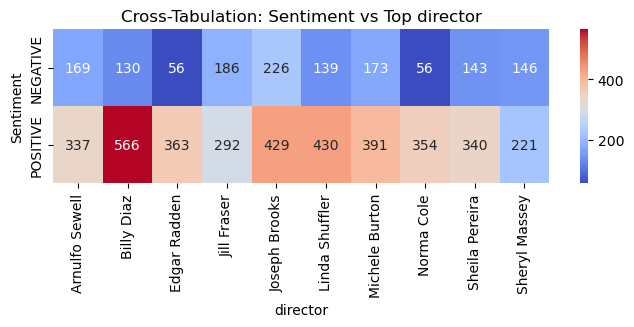

In [41]:
top_n = 10
top_genres = merged_train['director'].value_counts().head(top_n).index
filtered_df = merged_train[merged_train['director'].isin(top_genres)]

# Create a cross-tabulation for the filtered data
cross_tab_filtered = pd.crosstab(filtered_df['Sentiment'], filtered_df['director'], margins=True)
cross_tab_filtered = cross_tab_filtered.drop(columns='All', index='All')
# Create a heatmap using Seaborn
plt.figure(figsize=(8, 2))
sns.heatmap(cross_tab_filtered, cmap='coolwarm', annot=True, fmt='d')
plt.title("Cross-Tabulation: Sentiment vs Top director")
plt.xlabel("director")
plt.ylabel("Sentiment")
plt.show()

In [42]:
top_genres = merged_train['isFrequentReviewer'].value_counts().index
top_directors = merged_train['director'].value_counts().head(5).index

# Filter the merged_train DataFrame for the top genres and directors
filtered_df = merged_train[merged_train['isFrequentReviewer'].isin(top_genres) & merged_train['director'].isin(top_directors)]

# Create a pivot table to analyze the relationship
pivot_table = pd.pivot_table(filtered_df, index=['isFrequentReviewer', 'director'], columns='Sentiment', aggfunc='size', fill_value=0)

print(pivot_table)

Sentiment                          NEGATIVE  POSITIVE
isFrequentReviewer director                          
False              Arnulfo Sewell       113       236
                   Billy Diaz            98       433
                   Joseph Brooks        146       315
                   Linda Shuffler        90       296
                   Michele Burton       120       284
True               Arnulfo Sewell        56       101
                   Billy Diaz            32       133
                   Joseph Brooks         80       114
                   Linda Shuffler        49       134
                   Michele Burton        53       107


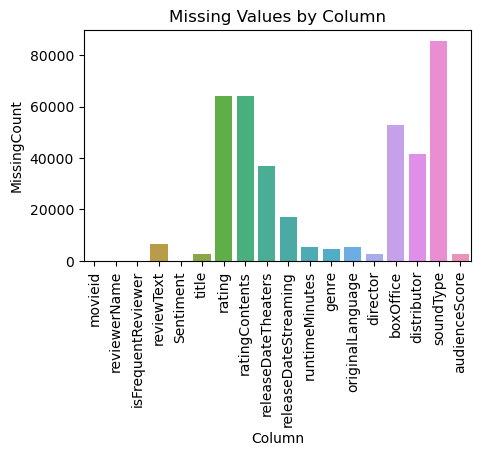

In [43]:
missing_values_df = merged_train.isnull().sum().reset_index()
missing_values_df.columns = ['Column', 'MissingCount']
plt.figure(figsize=(5,3))
sns.barplot(x='Column', y='MissingCount', data=missing_values_df)
plt.xticks(rotation=90)
plt.title("Missing Values by Column")
plt.show()


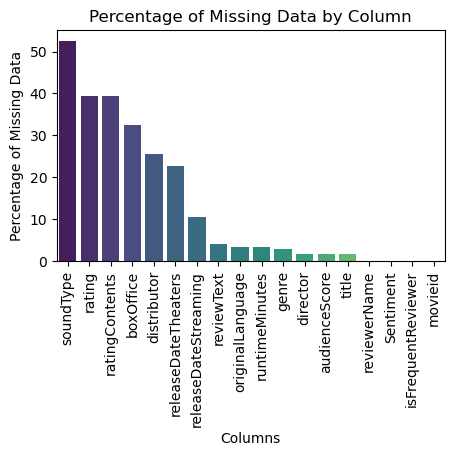

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
msg_percent = (merged_train.isnull().sum() / len(merged_train)) * 100
msg_percent = msg_percent.sort_values(ascending=False)
plt.figure(figsize=(5,3))
sns.barplot(x=msg_percent.index, y=msg_percent.values, palette='viridis')
plt.xticks(rotation=90)
plt.xlabel('Columns')
plt.ylabel('Percentage of Missing Data')
plt.title('Percentage of Missing Data by Column')
plt.show()

Many of the column has high missing values. These can potentially introduce inaccuracies or bias in our analysis and modeling.

In [45]:
columns_to_delete=['releaseDateTheaters','rating','ratingContents', 'releaseDateStreaming','director', 'originalLanguage', 'boxOffice','distributor', 'soundType','genre', 'runtimeMinutes', 'title','reviewerName']
merged_train.drop(columns=columns_to_delete, inplace=True)

In [46]:
merged_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162758 entries, 0 to 162757
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   movieid             162758 non-null  object 
 1   isFrequentReviewer  162758 non-null  bool   
 2   reviewText          156311 non-null  object 
 3   Sentiment           162758 non-null  object 
 4   audienceScore       159922 non-null  float64
dtypes: bool(1), float64(1), object(3)
memory usage: 6.4+ MB


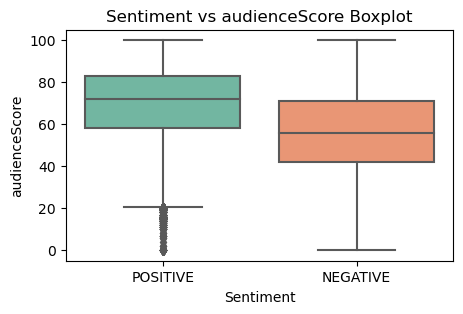

In [47]:
plt.figure(figsize=(5,3))
sns.boxplot(x='Sentiment', y='audienceScore', data=merged_train, palette='Set2')
plt.title('Sentiment vs audienceScore Boxplot')
plt.xlabel('Sentiment')
plt.ylabel('audienceScore')
plt.show()

In [48]:
Q1=merged_train['audienceScore'].quantile(0.25)
Q3=merged_train['audienceScore'].quantile(0.75)
IQR=Q3-Q1
lower_bound=Q1-1.5*IQR
upper_bound=Q3+1.5*IQR
outliers=merged_train[(merged_train['audienceScore'] < lower_bound) | (merged_train['audienceScore'] > upper_bound)]
print("No. of outliers:", len(outliers))

#merged_train = merged_train[(merged_train['audienceScore'] >= lower_bound) & (merged_train['audienceScore'] <= upper_bound)]

No. of outliers: 62


In [49]:
merged_train.reset_index(drop=True, inplace=True)

In [50]:
merged_train.shape

(162758, 5)

**2. Merging test_ and movie_ datasets based on the 'movie_id' column**

In [51]:
merged_test=pd.merge(test_data, movie_data, how='left')
columns_to_delete=[ 'title','reviewerName','releaseDateTheaters','rating','ratingContents', 'releaseDateStreaming','director', 'originalLanguage', 'boxOffice','distributor', 'soundType', 'audienceScore', 'genre', 'runtimeMinutes']
merged_test.drop(columns=columns_to_delete, inplace=True)
merged_test.head()

,movieid,isFrequentReviewer,reviewText,audienceScore_new
0,legend_marty_mcfly_oracle,False,Green slowly cranks up the dread with style an...,57.0
1,terminator_katniss_everdeen_glimmer,False,Philip Noyce's direction is elegant and unforc...,86.0
2,james_bond_labyrinth_gollum,False,It wouldn't do to say what path Maria ultimate...,62.0
3,v_quest_han_solo_wondrous,False,Pig is not exactly the arthouse John Wick that...,70.0
4,enigma_hulk_surreal_starlight,False,An imaginative no-budget musical of sorts abou...,NaN


In [52]:
merged_test.rename(columns={'audienceScore_new': 'audienceScore'}, inplace=True)
merged_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55315 entries, 0 to 55314
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   movieid             55315 non-null  object 
 1   isFrequentReviewer  55315 non-null  bool   
 2   reviewText          52805 non-null  object 
 3   audienceScore       53866 non-null  float64
dtypes: bool(1), float64(1), object(2)
memory usage: 1.7+ MB


In [53]:
print(train_data.shape,  merged_train.shape, test_data.shape, merged_test.shape)

(162758, 5) (162758, 5) (55315, 4) (55315, 4)


In [54]:
merged_test.isnull().sum()

movieid                  0
isFrequentReviewer       0
reviewText            2510
audienceScore         1449
dtype: int64

In [55]:
num_duplicated_rows=merged_test.duplicated().sum()
print("Number of unique rows in test_data =", len(merged_test)-num_duplicated_rows)
print("Number of duplicate rows= ", num_duplicated_rows)

Number of unique rows in test_data = 54916
Number of duplicate rows=  399


In [56]:
merged_test['reviewText_filled'] = merged_test.groupby('movieid')['reviewText'].transform(lambda x: x.ffill())
merged_test['reviewText_filled'].fillna('', inplace=True)
merged_test.head(2)

,movieid,isFrequentReviewer,reviewText,audienceScore,reviewText_filled
0,legend_marty_mcfly_oracle,False,Green slowly cranks up the dread with style an...,57.0,Green slowly cranks up the dread with style an...
1,terminator_katniss_everdeen_glimmer,False,Philip Noyce's direction is elegant and unforc...,86.0,Philip Noyce's direction is elegant and unforc...


Note: To handle missing 'reviewText' values, I filled them using the forward-fill method 

In [57]:
merged_test.isnull().sum()

movieid                  0
isFrequentReviewer       0
reviewText            2510
audienceScore         1449
reviewText_filled        0
dtype: int64

In [58]:
del merged_test['reviewText']
merged_test.rename(columns={'reviewText_filled': 'reviewText'}, inplace=True)
merged_test.isnull().sum()

movieid                  0
isFrequentReviewer       0
audienceScore         1449
reviewText               0
dtype: int64

In [59]:
print(merged_train.shape, merged_test.shape)

(162758, 5) (55315, 4)


# Preprocessing Text data

In [60]:
#merged_train=merged_train.dropna(subset=['reviewText'])
merged_train['reviewText'].fillna('', inplace=True)

In [61]:
reviewtext_sample=merged_train['reviewText'][1000]
reviewtext_sample

"It sounds like the latest release from Blumhouse Productions, but the documentary from filmmakers Shannon Service and Jeffrey Waldron is more frightening than any fabricated specter as the underbelly of Thailand's seafood trade is exposed."

In [62]:
def preprocess_text(text):
    # Basic preprocessing steps
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\b\w*\d\w*\b', '', text)
    text = re.sub('[''""]', '', text)
    text = re.sub('\n', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'http\S+|www\S+|https\S+|\S+@\S+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r':\)|:\(|<3', '', text)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    text = re.sub(r'\s+', ' ', text)
    
    # Contractions handling
    contractions = {
        "don't": "do not",
        "it's": "it is",
    }
    for contraction, expanded in contractions.items():
        text = text.replace(contraction, expanded)
    return text


In [63]:
merged_train['reviewText'] = merged_train['reviewText'].apply(preprocess_text)
merged_test['reviewText'] = merged_test['reviewText'].apply(preprocess_text)

In [64]:
reviewtext_sample=merged_train['reviewText'][1000]
reviewtext_sample

'it sounds like the latest release from blumhouse productions but the documentary from filmmakers shannon service and jeffrey waldron is more frightening than any fabricated specter as the underbelly of thailands seafood trade is exposed'

# Text Vectorization

Converting text data into  numerical features

In [65]:
#vectorizer=CountVectorizer(stop_words='english',strip_accents='unicode', lowercase=True, ngram_range=(1, 3))
vectorizer=TfidfVectorizer(stop_words='english',strip_accents='unicode', lowercase=True, ngram_range=(1, 3))
train_tf =vectorizer.fit_transform(merged_train['reviewText'])
test_tf = vectorizer.transform(merged_test['reviewText'])

# Handling Missing Data

In [66]:
numerical_features = merged_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = merged_train.select_dtypes(include=['object']).columns.tolist()
boolean_features = merged_train.select_dtypes(include=['bool']).columns.tolist()
print('Numerical_features:  ', numerical_features, '\nCategorical_features:', categorical_features, '\nBoolean_features:    ', boolean_features)

Numerical_features:   ['audienceScore'] 
Categorical_features: ['movieid', 'reviewText', 'Sentiment'] 
Boolean_features:     ['isFrequentReviewer']


In [67]:
train_merged=merged_train.drop(columns=['reviewText', 'Sentiment'])
test_merged=merged_test.drop(columns=['reviewText'])

In [68]:
print(merged_train.shape, train_merged.shape, test_merged.shape)

(162758, 5) (162758, 3) (55315, 3)


In [69]:
numerical_cols=['audienceScore'] 
categorical_cols= ['movieid'] 
boolean_cols=['isFrequentReviewer']

# Imputation

In [70]:
num_pipeline=Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('scaler', MinMaxScaler())
       ])
cat_pipeline=Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='content')),
        ('hashing', HashingEncoder()),
       ])
bool_pipeline = Pipeline([
      ('bool_encoder', BinaryEncoder())
])

In [71]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipeline,numerical_cols),
        ('cat', cat_pipeline,categorical_cols),
        ('bool', bool_pipeline, boolean_cols),
        ], remainder='passthrough', verbose_feature_names_out=False,)

       # 

In [72]:
transformed_train = preprocessor.fit_transform(train_merged)
transformed_test=preprocessor.transform(test_merged)

In [73]:
preprocessor.get_feature_names_out() #returns the list of feature names after the transformation applied by the ColumnTransformer

array(['audienceScore', 'col_0', 'col_1', 'col_2', 'col_3', 'col_4',
       'col_5', 'col_6', 'col_7', 'isFrequentReviewer'], dtype=object)

In [74]:
from scipy.sparse import hstack
train_combined = hstack((transformed_train, train_tf))
test_combined = hstack((transformed_test, test_tf))

In [75]:
print(train_combined.shape, test_combined.shape)

(162758, 2596637) (55315, 2596637)


**Preparing target variable and feature matrix**

In [76]:
y = merged_train['Sentiment'].apply(lambda x: 1 if x == 'POSITIVE' else 0) #target variable
X = train_combined #feature matrix

In [77]:
assert X.shape[0] == y.shape[0], "Number of samples in X and y are not equal"
print("Shapes are consistent")

Shapes are consistent


# Train-Test-split

In [78]:
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.3, random_state=42)

In [79]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(113930, 2596637) (48828, 2596637) (113930,) (48828,)


# Feature Selection

In [80]:
selector = SelectKBest(score_func=chi2, k=10000)
#selector = SelectPercentile(score_func=chi2, percentile=0.3)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

In [81]:
type(X_train_selected)

scipy.sparse._csr.csr_matrix

# Model Building

In [82]:
#Best performing models (3)
#classifier = BaggingClassifier(estimator=LogisticRegression())
classifier = LinearSVC(max_iter=1000)
#classifier = MLPClassifier()

In [83]:
#classifier=LogisticRegression(max_iter=1000)
#classifier=DecisionTreeClassifier()
#classifier=GradientBoostingClassifier()
#classifier=RandomForestClassifier()
#classifier=SGDClassifier()
#classifier=MultinomialNB()
#classifier = KNeighborsClassifier()
#classifier=AdaBoostClassifier(estimator=RandomForestClassifier())

In [84]:
'''
estimator=LogisticRegression(max_iter=1000, random_state=42)
classifier = BaggingClassifier(estimator=estimator, n_jobs=-1)
'''

'\nestimator=LogisticRegression(max_iter=1000, random_state=42)\nclassifier = BaggingClassifier(estimator=estimator, n_jobs=-1)\n'

In [85]:
'''
estimator=LinearSVC(C = 0.4, 
                   fit_intercept = True, 
                    loss ='squared_hinge', 
                    penalty = 'l2',
                    max_iter=10000)
classifier = BaggingClassifier(estimator=estimator, n_jobs=-1)
'''

"\nestimator=LinearSVC(C = 0.4, \n                   fit_intercept = True, \n                    loss ='squared_hinge', \n                    penalty = 'l2',\n                    max_iter=10000)\nclassifier = BaggingClassifier(estimator=estimator, n_jobs=-1)\n"

In [86]:
'''
classifier = MLPClassifier(
    hidden_layer_sizes=(100, 100),  
    alpha=0.001,  
    learning_rate='adaptive',
    max_iter=1000,
    random_state=42,
    validation_fraction=0.1,
    n_iter_no_change=10,
    batch_size=128,
    solver='sgd'
)
'''

"\nclassifier = MLPClassifier(\n    hidden_layer_sizes=(100, 100),  \n    alpha=0.001,  \n    learning_rate='adaptive',\n    max_iter=1000,\n    random_state=42,\n    validation_fraction=0.1,\n    n_iter_no_change=10,\n    batch_size=128,\n    solver='sgd'\n)\n"

In [87]:
'''
classifier = MLPClassifier(alpha=0.001, 
                           batch_size=100, 
                           early_stopping=True,
                           hidden_layer_sizes=300, 
                           learning_rate='adaptive',
                           max_iter=1000,
                           random_state=42, 
                           solver='sgd')
'''

"\nclassifier = MLPClassifier(alpha=0.001, \n                           batch_size=100, \n                           early_stopping=True,\n                           hidden_layer_sizes=300, \n                           learning_rate='adaptive',\n                           max_iter=1000,\n                           random_state=42, \n                           solver='sgd')\n"

In [88]:
'''
classifier=LinearSVC(C= 1.0, 
                     class_weight = 'balanced', 
                     fit_intercept = True,
                     loss = 'squared_hinge', 
                     penalty = 'l2',
                     max_iter=10000)
 '''

"\nclassifier=LinearSVC(C= 1.0, \n                     class_weight = 'balanced', \n                     fit_intercept = True,\n                     loss = 'squared_hinge', \n                     penalty = 'l2',\n                     max_iter=10000)\n "

In [89]:
'''
from sklearn.linear_model import Perceptron
perceptron = Perceptron(penalty='l2', alpha=0.001, max_iter=200, eta0=0.1)
'''

"\nfrom sklearn.linear_model import Perceptron\nperceptron = Perceptron(penalty='l2', alpha=0.001, max_iter=200, eta0=0.1)\n"

In [90]:
'''
chunksize = 128
num_samples = X_train_selected.shape[0]
num_batches = (num_samples + chunksize - 1) // chunksize

for batch_idx in range(num_batches):
    start_idx = batch_idx * chunksize
    end_idx = min((batch_idx + 1) * chunksize, num_samples)
    train_chunk = X_train_selected[start_idx:end_idx]
    y_chunk = y_train[start_idx:end_idx]
    classifier.partial_fit(train_chunk, y_chunk, classes=np.array([0, 1]))
   
'''

'\nchunksize = 128\nnum_samples = X_train_selected.shape[0]\nnum_batches = (num_samples + chunksize - 1) // chunksize\n\nfor batch_idx in range(num_batches):\n    start_idx = batch_idx * chunksize\n    end_idx = min((batch_idx + 1) * chunksize, num_samples)\n    train_chunk = X_train_selected[start_idx:end_idx]\n    y_chunk = y_train[start_idx:end_idx]\n    classifier.partial_fit(train_chunk, y_chunk, classes=np.array([0, 1]))\n   \n'

# Hyperparameter Grid

In [91]:
'''
#LogisticRegression
param_grid = {
    'penalty': ['l1', 'l2'],                 
    'C': [0.01, 0.1, 1.0, 10.0],               
    'solver': ['liblinear', 'saga'],         
    'fit_intercept': [True, False],          
    'warm_start': [True, False],              
    'intercept_scaling': [1, 2, 3],           
}
'''

"\n#LogisticRegression\nparam_grid = {\n    'penalty': ['l1', 'l2'],                 \n    'C': [0.01, 0.1, 1.0, 10.0],               \n    'solver': ['liblinear', 'saga'],         \n    'fit_intercept': [True, False],          \n    'warm_start': [True, False],              \n    'intercept_scaling': [1, 2, 3],           \n}\n"

In [92]:
'''
#BaggingClassifier(LogisticRegression)
param_grid = {
    'n_estimators': [50, 100, 200],         
    'max_samples': [0.5, 0.8, 1.0],         
    'max_features': [0.5, 0.8, 1.0],        
    'bootstrap': [True, False],             
    'estimator__C': [0.1, 1, 10],      
    'estimator__solver': ['liblinear', 'lbfgs']
}
'''

"\n#BaggingClassifier(LogisticRegression)\nparam_grid = {\n    'n_estimators': [50, 100, 200],         \n    'max_samples': [0.5, 0.8, 1.0],         \n    'max_features': [0.5, 0.8, 1.0],        \n    'bootstrap': [True, False],             \n    'estimator__C': [0.1, 1, 10],      \n    'estimator__solver': ['liblinear', 'lbfgs']\n}\n"

In [93]:
#LinearSVC
param_grid = {
 'C': [0.01, 0.1, 1.0, 10.0],  
    'loss': ['hinge', 'squared_hinge'],
    'class_weight': [None, 'balanced'],
    'max_iter': [1000, 2000, 3000, 5000],
    'dual': [True, False],
    'tol': [1e-4, 1e-3, 1e-2],
    'penalty': ['l1', 'l2'],
    'intercept_scaling': [1, 2, 3],
    'fit_intercept': [True, False],
    'random_state': [42],
}


In [94]:
'''
#LinearSVC
param_dist = {
    'C': [0.01, 0.1, 1.0, 10.0],  
    'loss': ['hinge', 'squared_hinge'],
    'class_weight': [None, 'balanced'],
    'max_iter': [1000, 2000, 3000, 5000],
    'dual': [True, False],
    'tol': [1e-4, 1e-3, 1e-2],
    'penalty': ['l1', 'l2'],
    'intercept_scaling': [1, 2, 3],
    'fit_intercept': [True, False],
    'random_state': [42],
}
'''

"\n#LinearSVC\nparam_dist = {\n    'C': [0.01, 0.1, 1.0, 10.0],  \n    'loss': ['hinge', 'squared_hinge'],\n    'class_weight': [None, 'balanced'],\n    'max_iter': [1000, 2000, 3000, 5000],\n    'dual': [True, False],\n    'tol': [1e-4, 1e-3, 1e-2],\n    'penalty': ['l1', 'l2'],\n    'intercept_scaling': [1, 2, 3],\n    'fit_intercept': [True, False],\n    'random_state': [42],\n}\n"

In [95]:
'''
#BaggingClassifier(LinearSVC)
param_grid = {
    'n_estimators': [10, 50, 100, 200],         
    'max_samples': [0.5, 0.8, 1.0],         
    'max_features': [0.5, 0.8, 1.0],        
     'bootstrap': [True, False],  
    'bootstrap_features': [True, False]     
}
#'estimator__C': [0.1, 1, 10],
'''

"\n#BaggingClassifier(LinearSVC)\nparam_grid = {\n    'n_estimators': [10, 50, 100, 200],         \n    'max_samples': [0.5, 0.8, 1.0],         \n    'max_features': [0.5, 0.8, 1.0],        \n     'bootstrap': [True, False],  \n    'bootstrap_features': [True, False]     \n}\n#'estimator__C': [0.1, 1, 10],\n"

In [96]:
'''
#MLPClassifier
param_grid = {
    'hidden_layer_sizes': [(200,), (300,)],
    'alpha': [0.001, 0.01, 0.1],
    'learning_rate': ['adaptive'],
    'max_iter': [1000],
    'random_state': [42],  
    'early_stopping': [True],
    'validation_fraction': [0.1],
    'n_iter_no_change': [10],
    'batch_size': [32],
    }
'''

"\n#MLPClassifier\nparam_grid = {\n    'hidden_layer_sizes': [(200,), (300,)],\n    'alpha': [0.001, 0.01, 0.1],\n    'learning_rate': ['adaptive'],\n    'max_iter': [1000],\n    'random_state': [42],  \n    'early_stopping': [True],\n    'validation_fraction': [0.1],\n    'n_iter_no_change': [10],\n    'batch_size': [32],\n    }\n"

In [97]:
'''
#MLPClassifier
param_dist = {
    'hidden_layer_sizes': [(150,), (100,),(200), (50, 50), (100, 50), (100, 100)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive'],
    'max_iter': [1000, 2000, 3000],
    'batch_size': [32, 64, 128]
}
'''


"\n#MLPClassifier\nparam_dist = {\n    'hidden_layer_sizes': [(150,), (100,),(200), (50, 50), (100, 50), (100, 100)],\n    'activation': ['relu', 'tanh'],\n    'solver': ['adam', 'sgd'],\n    'alpha': [0.0001, 0.001, 0.01],\n    'learning_rate': ['constant', 'adaptive'],\n    'max_iter': [1000, 2000, 3000],\n    'batch_size': [32, 64, 128]\n}\n"

In [98]:
'''
#DecisionTreeClassifier
param_grid={'criterion': ['gini', 'entropy'],
            'max_depth': [None, 5, 10, 20, 30]}
'''

"\n#DecisionTreeClassifier\nparam_grid={'criterion': ['gini', 'entropy'],\n            'max_depth': [None, 5, 10, 20, 30]}\n"

In [99]:
'''
#GradientBoostingClassifier
param_grid={'n_estimators': [100,200,300],
            'learning_rate': [0.01,0.1,0.5],
            'max_depth': [3,5,7],
            'min_samples_split':[2,5,10],
            'min_samples_leaf':[1,2,4]}
'''

"\n#GradientBoostingClassifier\nparam_grid={'n_estimators': [100,200,300],\n            'learning_rate': [0.01,0.1,0.5],\n            'max_depth': [3,5,7],\n            'min_samples_split':[2,5,10],\n            'min_samples_leaf':[1,2,4]}\n"

In [100]:
'''
#RandomForestClassifier
param_grid={'n_estimators': [100,200,300],
            'max_depth': [None, 5,10,20],
            'min_samples_split':[2,5,10],
            'min_samples_leaf':[1,2,4]}
'''

"\n#RandomForestClassifier\nparam_grid={'n_estimators': [100,200,300],\n            'max_depth': [None, 5,10,20],\n            'min_samples_split':[2,5,10],\n            'min_samples_leaf':[1,2,4]}\n"

In [101]:
'''
#SGDClassifier
param_grid = {
    'C': [0.1, 1.0, 10.0],
    'penalty': ['l1', 'l2'],
    'loss': ['hinge', 'squared_hinge'],
    'dual': [True, False],
    'tol': [1e-3, 1e-4, 1e-5],
    'fit_intercept': [True, False]
}
'''

"\n#SGDClassifier\nparam_grid = {\n    'C': [0.1, 1.0, 10.0],\n    'penalty': ['l1', 'l2'],\n    'loss': ['hinge', 'squared_hinge'],\n    'dual': [True, False],\n    'tol': [1e-3, 1e-4, 1e-5],\n    'fit_intercept': [True, False]\n}\n"

In [102]:
'''
#MultinomialNB
param_grid = {
    'alpha': [0.01, 0.1, 0.5, 1.0, 2.0, 10.0],  
    'fit_prior': [True, False]  
}
'''

"\n#MultinomialNB\nparam_grid = {\n    'alpha': [0.01, 0.1, 0.5, 1.0, 2.0, 10.0],  \n    'fit_prior': [True, False]  \n}\n"

In [103]:
'''
#MultinomialNB
param_dist = {
    'alpha': [0.01, 0.1, 0.5, 1.0, 2.0],  
    'fit_prior': [True, False],  
    'class_prior': [None, [0.7, 0.3], [0.6, 0.4], [0.5, 0.5]],  
}
'''

"\n#MultinomialNB\nparam_dist = {\n    'alpha': [0.01, 0.1, 0.5, 1.0, 2.0],  \n    'fit_prior': [True, False],  \n    'class_prior': [None, [0.7, 0.3], [0.6, 0.4], [0.5, 0.5]],  \n}\n"

In [104]:
'''
#Bagging Classifier
param_dist = {
    'n_estimators': [50, 100, 200], 
    'max_samples': [0.5, 0.7, 0.8, 1.0],  
    'max_features': [0.5, 0.7, 0.8, 1.0], 
    'bootstrap': [True, False],  
    'bootstrap_features': [True, False]  
}
'''

"\n#Bagging Classifier\nparam_dist = {\n    'n_estimators': [50, 100, 200], \n    'max_samples': [0.5, 0.7, 0.8, 1.0],  \n    'max_features': [0.5, 0.7, 0.8, 1.0], \n    'bootstrap': [True, False],  \n    'bootstrap_features': [True, False]  \n}\n"

In [105]:
'''
#KNeighborsClassifier
param_dist = {
    'n_neighbors': np.arange(1, 11),  
    'metric': ['euclidean', 'manhattan', 'cosine', 'chebyshev']
}
'''

"\n#KNeighborsClassifier\nparam_dist = {\n    'n_neighbors': np.arange(1, 11),  \n    'metric': ['euclidean', 'manhattan', 'cosine', 'chebyshev']\n}\n"

# GridSearchCV

In [106]:
grid_search=GridSearchCV(estimator=classifier, param_grid=param_grid, cv=5, scoring='f1')
grid_search.fit(X_train_selected, y_train)

/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

GridSearchCV(cv=5, estimator=LinearSVC(),
             param_grid={'C': [0.01, 0.1, 1.0, 10.0],
                         'class_weight': [None, 'balanced'],
                         'dual': [True, False], 'fit_intercept': [True, False],
                         'intercept_scaling': [1, 2, 3],
                         'loss': ['hinge', 'squared_hinge'],
                         'max_iter': [1000, 2000, 3000, 5000],
                         'penalty': ['l1', 'l2'], 'random_state': [42],
                         'tol': [0.0001, 0.001, 0.01]},
             scoring='f1')

# RandomizedSearchCV

In [107]:
'''
random_search = RandomizedSearchCV(classifier, param_distributions=param_dist, n_iter=5, cv=2, n_jobs=-1, scoring='f1', verbose=1)
random_search.fit(X_train_selected, y_train)
'''

"\nrandom_search = RandomizedSearchCV(classifier, param_distributions=param_dist, n_iter=5, cv=2, n_jobs=-1, scoring='f1', verbose=1)\nrandom_search.fit(X_train_selected, y_train)\n"

In [108]:
best_params=grid_search.best_params_
best_classifier=grid_search.best_estimator_
print(best_params, best_classifier)


{'C': 10.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 2, 'loss': 'squared_hinge', 'max_iter': 1000, 'penalty': 'l2', 'random_state': 42, 'tol': 0.0001} LinearSVC(C=10.0, dual=False, intercept_scaling=2, random_state=42)


In [109]:
'''
best_params=random_search.best_params_
best_classifier=random_search.best_estimator_
print(best_params, best_classifier)
'''

'\nbest_params=random_search.best_params_\nbest_classifier=random_search.best_estimator_\nprint(best_params, best_classifier)\n'

In [110]:
'''
# Initialize base classifiers
mlp_classifier = MLPClassifier(alpha=0.001, batch_size=100, early_stopping=True,
              hidden_layer_sizes=300, learning_rate='adaptive', max_iter=1000,
              random_state=42, solver='sgd')

lr_classifier = LogisticRegression(max_iter=1000, solver='liblinear')

svc_classifier = LinearSVC(C=0.1, max_iter=10000, class_weight=None,
                           fit_intercept= True, loss = 'squared_hinge', penalty= 'l2')

# Create a voting classifier (soft voting)
classifier = VotingClassifier(
    estimators=[('mlp', mlp_classifier), ('lr', lr_classifier), ('svc', svc_classifier)],
    voting='hard'
)

# Train the voting classifier
classifier.fit(X_train_selected, y_train)
'''

"\n# Initialize base classifiers\nmlp_classifier = MLPClassifier(alpha=0.001, batch_size=100, early_stopping=True,\n              hidden_layer_sizes=300, learning_rate='adaptive', max_iter=1000,\n              random_state=42, solver='sgd')\n\nlr_classifier = LogisticRegression(max_iter=1000, solver='liblinear')\n\nsvc_classifier = LinearSVC(C=0.1, max_iter=10000, class_weight=None,\n                           fit_intercept= True, loss = 'squared_hinge', penalty= 'l2')\n\n# Create a voting classifier (soft voting)\nclassifier = VotingClassifier(\n    estimators=[('mlp', mlp_classifier), ('lr', lr_classifier), ('svc', svc_classifier)],\n    voting='hard'\n)\n\n# Train the voting classifier\nclassifier.fit(X_train_selected, y_train)\n"

In [111]:
#classifier.fit(X_train_selected, y_train)

In [112]:
#predictions on both the training and testing datasets
y_pred_train =best_classifier.predict(X_train_selected)
y_pred_test =best_classifier.predict(X_test_selected)
print("Predicted Labels: ", y_pred_test)

Predicted Labels:  [1 0 0 ... 1 0 1]


# Model Evaluation

In [113]:
train_accuracy = accuracy_score(y_train, y_pred_train)
train_precision = precision_score(y_train, y_pred_train)
train_recall = recall_score(y_train, y_pred_train)
train_f1 = f1_score(y_train, y_pred_train)

test_accuracy = accuracy_score(y_test, y_pred_test)
test_precision = precision_score(y_test, y_pred_test)
test_recall = recall_score(y_test, y_pred_test)
test_f1 = f1_score(y_test, y_pred_test)

print("Evaluation metrics on training data:\n")
print("Training Accuracy:", train_accuracy)
print("Training Precision:", train_precision)
print("Training Recall:", train_recall)
print("Training F1 Score:", train_f1)
print("\nEvaluation metrics on test data:\n")
print("Test Accuracy:", test_accuracy)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)
print("Test F1 Score:", test_f1)


Evaluation metrics on training data:

Training Accuracy: 0.8526902483981392
Training Precision: 0.8574457065079919
Training Recall: 0.9350093256626474
Training F1 Score: 0.8945493386949828

Evaluation metrics on test data:

Test Accuracy: 0.7989678053575817
Test Precision: 0.8132260456430396
Test Recall: 0.9075918717626505
Test F1 Score: 0.857821552723059


In [114]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.76      0.58      0.66     16201
           1       0.81      0.91      0.86     32627

    accuracy                           0.80     48828
   macro avg       0.79      0.74      0.76     48828
weighted avg       0.79      0.80      0.79     48828



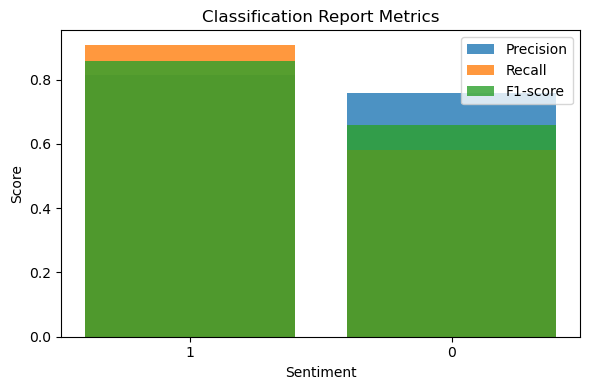

In [115]:
report = classification_report(y_test, y_pred_test, output_dict=True)
class_names = ['1', '0'] 

precision = [report[class_name]['precision'] for class_name in class_names]
recall = [report[class_name]['recall'] for class_name in class_names]
f1_score = [report[class_name]['f1-score'] for class_name in class_names]

plt.figure(figsize=(6,4))
plt.bar(class_names, precision, label='Precision', alpha=0.8)
plt.bar(class_names, recall, label='Recall', alpha=0.8)
plt.bar(class_names, f1_score, label='F1-score', alpha=0.8)

plt.xlabel('Sentiment')
plt.ylabel('Score')
plt.title('Classification Report Metrics')
plt.legend()
plt.tight_layout()
plt.show()

In [116]:
class_labels = np.unique(y_test)

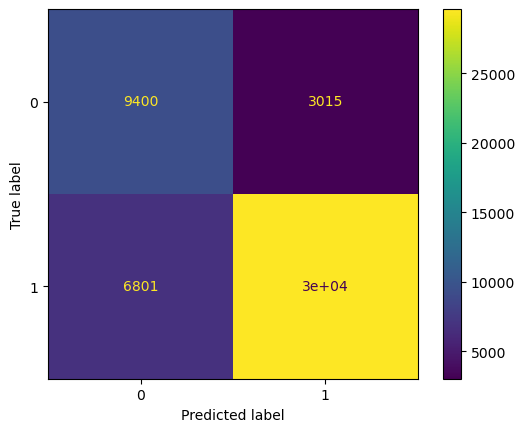

In [117]:
cm=confusion_matrix(y_pred_test, y_test)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels).plot()

In [118]:
precision_train, recall_train, _ = precision_recall_curve(y_train, y_pred_train)
precision_test, recall_test, _ = precision_recall_curve(y_test, y_pred_test)

fpr_train, tpr_train, _ = roc_curve(y_train, y_pred_train)
fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_test)
roc_auc_train = auc(fpr_train, tpr_train)
roc_auc_test = auc(fpr_test, tpr_test)


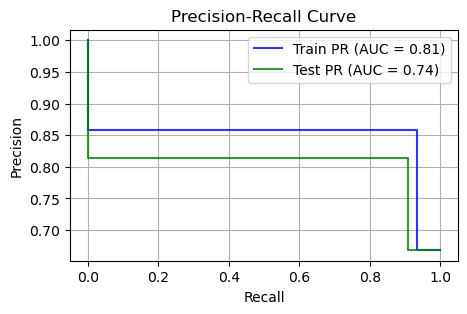

In [119]:
plt.figure(figsize=(5,3))
plt.step(recall_train, precision_train, color='b', alpha=0.8, where='post', label='Train PR (AUC = %0.2f)' % roc_auc_train)
plt.step(recall_test, precision_test, color='g', alpha=0.8, where='post', label='Test PR (AUC = %0.2f)' % roc_auc_test)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.grid()
plt.show()

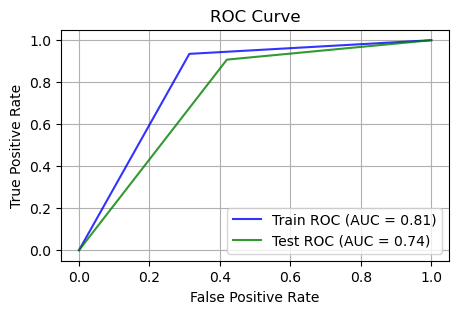

In [120]:
plt.figure(figsize=(5,3))
plt.plot(fpr_train, tpr_train, color='b', alpha=0.8, label='Train ROC (AUC = %0.2f)' % roc_auc_train)
plt.plot(fpr_test, tpr_test, color='g', alpha=0.8, label='Test ROC (AUC = %0.2f)' % roc_auc_test)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.grid()
plt.show()


In [121]:
from sklearn.metrics import matthews_corrcoef
mcc = matthews_corrcoef(y_pred_test, y_test)
mcc


0.5274755456085225

An MCC value greater than 0.5 suggests that classifier is performing well, with a positive correlation between predicted and actual classifications.

# Model Comparison

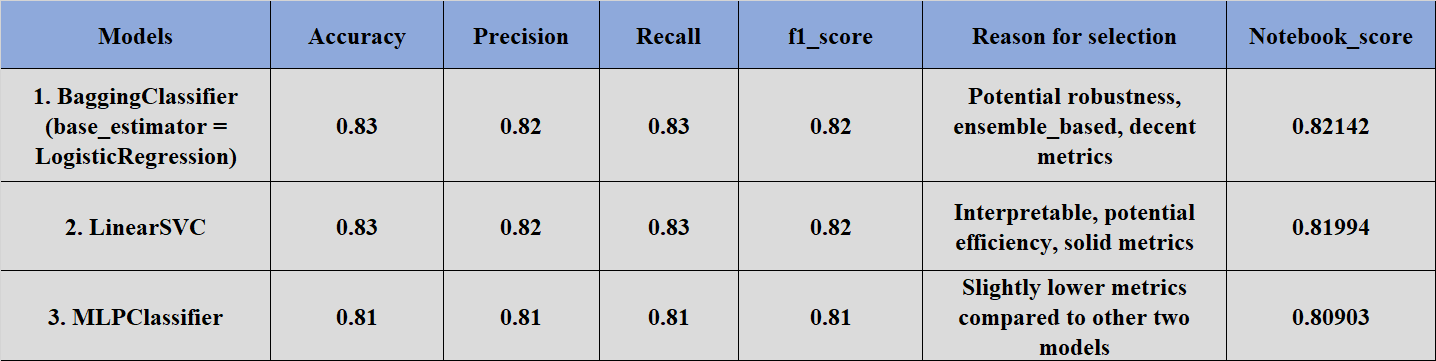

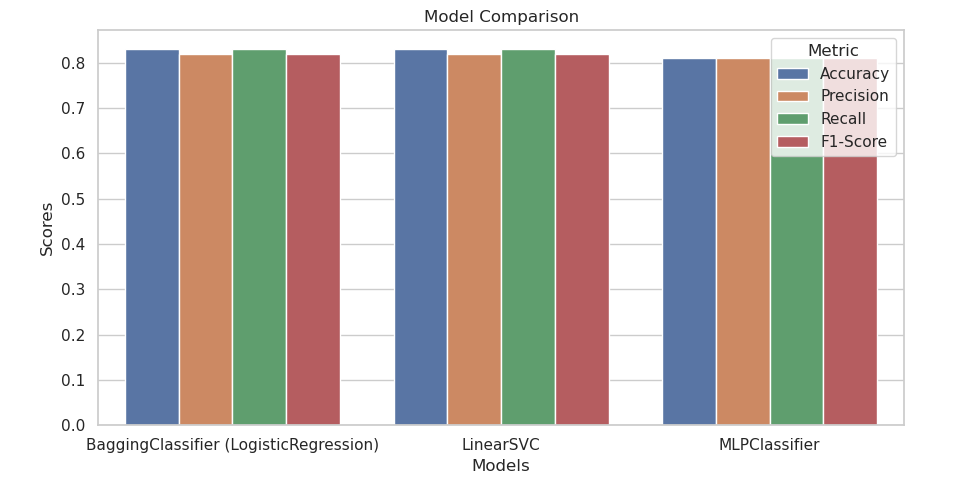

| Model                                | Description                                                                                                   | Hyperparameters                               | Best Parameters                                 | Pros                                          | Cons                                           | Evaluation Metric | 
|--------------------------------------|---------------------------------------------------------------------------------------------------------------|-----------------------------------------------|------------------------------------------------|-----------------------------------------------|------------------------------------------------|------------------|
| Bagging with Logistic Regression     | Ensemble technique using Logistic Regression as base estimator to enhance accuracy and control overfitting | Number of base estimators, max_samples, max_features, base_estimator's C parameter | BaggingClassifier(estimator=LogisticRegression(class_weight={0: 1.2, 1: 1.0}, max_iter=1000), max_features=0.8, n_estimators=100, n_jobs=-1) | Ensemble approach, improved generalization | Complexity, potential computational intensity | F1 score         |
| Linear Support Vector Classifier    | Linear classification using Support Vector Classifier with hyperplane separation                           | C (regularization parameter)                 | {'C': 1.0, 'class_weight': None, 'fit_intercept': True, 'loss': 'squared_hinge', 'penalty': 'l2'} LinearSVC(max_iter=10000) | Effective for linearly separable data       | Prone to overfitting, may struggle with non-linear data | F1 score         |
| Multilayer Perceptron                | Neural network-based classification model                                                               | Various parameters related to network architecture and training | MLPClassifier(alpha=0.001, batch_size=100, early_stopping=True, hidden_layer_sizes=300, learning_rate='adaptive', max_iter=1000, random_state=42, solver='sgd') | Ability to capture complex relationships | Sensitive to hyperparameters, potential overfitting | F1 score         |


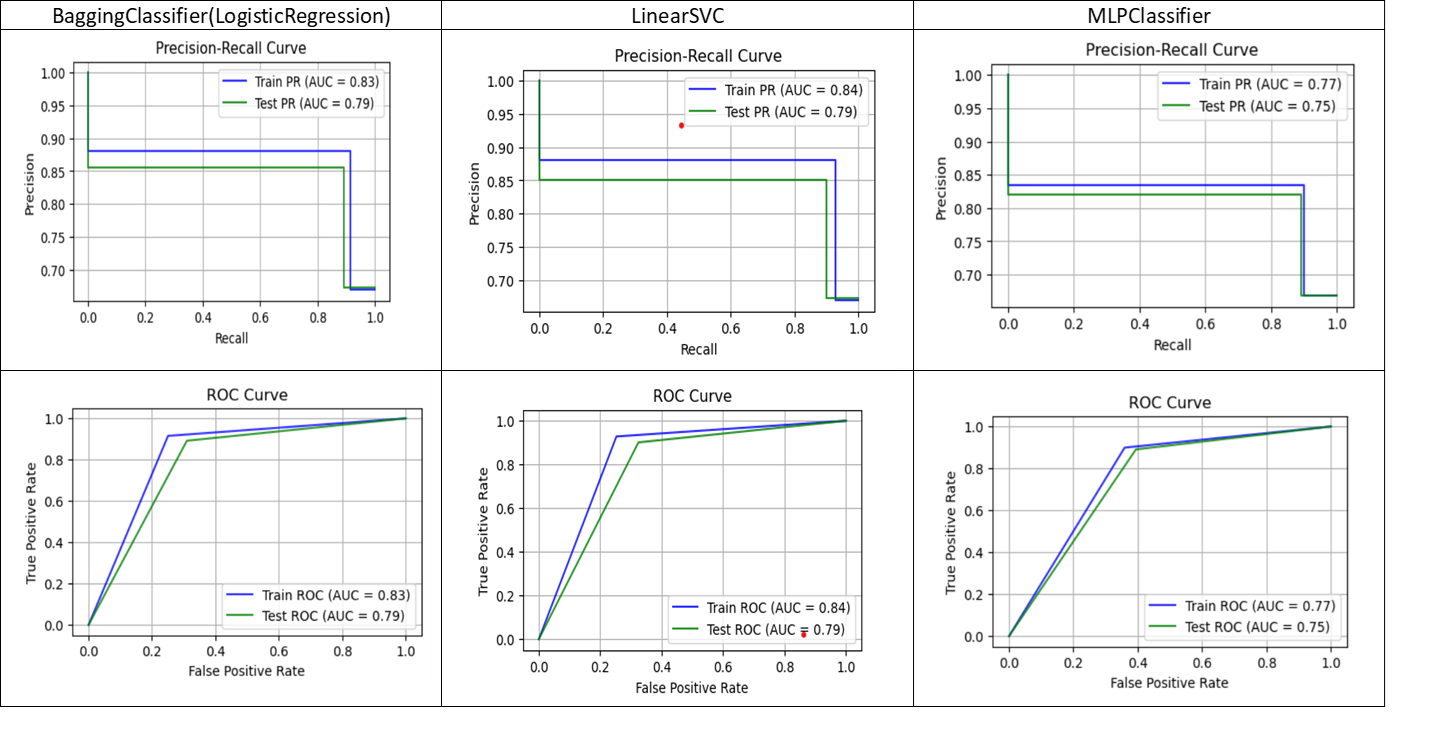


## Conclusion

Based on the F1 scores, hyperparameter tuning, and AUC analysis, I observed that the LinearSVC model performed the best among the three models on the test dataset. It achieved an accuracy of 0.81994 with hyperparameters tuned to (C=1.0, class_weight='balanced', max_iter=1000). The AUC analysis also indicated consistent performance, with the model achieving an AUC of approximately 0.79 on the validation set.

Although the Bagging model with Logistic Regression as the base estimator achieved a competitive accuracy of 0.82142 on the test dataset, it might be prone to overfitting due to its complexity, particularly on non-linear data. This suggests that while the Bagging model offers benefits through ensemble techniques, the LinearSVC model demonstrates strong performance in generalization to unseen data and simplicity in modeling linearly separable data.

# Submission on test data

In [122]:
test_df_selected = selector.transform(test_combined)
y_test_pred=best_classifier.predict(test_df_selected)
print(y_test_pred)


[1 1 1 ... 0 1 0]


In [123]:
predicted_labels = pd.DataFrame(columns=['id','sentiment'])
predicted_labels['id'] = [i for i in range(len(y_test_pred))]
predicted_labels['sentiment'] = y_test_pred


In [124]:
def convert_label_to_sentiment(label):
    sentiment_mapping = {0: 'NEGATIVE', 1: 'POSITIVE'}
    return sentiment_mapping[label]

predicted_labels['sentiment'] = predicted_labels['sentiment'].map(convert_label_to_sentiment)

In [125]:
predicted_labels.to_csv('submission.csv', index=False)
print(predicted_labels.head(5))

   id sentiment
0   0  POSITIVE
1   1  POSITIVE
2   2  POSITIVE
3   3  POSITIVE
4   4  POSITIVE


In [126]:
predicted_labels.shape

(55315, 2)